<a href="https://colab.research.google.com/github/kennethjiang/3DPrintSaviour/blob/master/Anomaly_Detection_Nezih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

from glob import glob
glob("/content/drive/MyDrive/timelapses/*", recursive = False)

In [29]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]

In [24]:
%pip install sewar==0.4.5

import cv2
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# from sewar.full_ref import mse, rmse, psnr, uqi, ergas, scc, rase, sam, msssim, vifp
from sewar.full_ref import mse, rmse
from skimage.metrics import structural_similarity as ssim
import os
from sklearn.cluster import DBSCAN
import scipy
import scipy.signal
from numpy import linalg as LA
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import logging
import math
from shapely.geometry import Polygon, Point




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
def read_next_frame(cap):
  """
  Read the next frame from the video, and resize MAX_WIDTH if necessary.
  """
  resize = 0
  width = int(cap.get(3))
  height = int(cap.get(4))
  if width>MAX_WIDTH:
    dividor = MAX_WIDTH/width
    height = int(dividor*height)
    width = MAX_WIDTH
    resize = 1

  _, frame = cap.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if resize:
    return cv2.resize(frame, (width,height), interpolation= cv2.INTER_LINEAR)
  else:
    return frame


In [65]:
def extractSIFT(frame):
    """
    Extracts SIFT features from the frame
    """
    # Gaussian blur kernel size:
    blur_kernel = 5

    # Get frame dimensions:
    width = frame.shape[1]
    height = frame.shape[0]

    # extract RootSIFT descriptors
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()

    # Gaussian blur:
    frame = cv2.GaussianBlur(frame,(blur_kernel,blur_kernel),0)

    # Copy of the frame:
    # frameOrg = frame.copy()

    # Another copy of the frame (for drawing clusters):
    # imageToDrawClusters = frame.copy()

    # Extract SIFT features:
    return sift.detectAndCompute(frame.astype(np.uint8),None)

In [63]:
def getFeaturesMask(frame, kps, savePNG = False):
    """
    Returns a mask created by these features.
    But how? What kind of role does DBSCAN plays? Nezih Topaloglu please elaborate!
    """

    # DBSCAN parameters:
    eps = 15
    min_samples = 3

    number_of_dilation_iterations = 12

    # Definition of arrays:
    siftArray = []
    maskXarray = []
    maskYarray = []

    # The x and y coordinates of keypoints are stored in separate arrays:
    for i in range(len(kps)):
        maskX = int(kps[i].pt[0])
        maskY = int(kps[i].pt[1])
        maskXarray.append(maskX)
        maskYarray.append(maskY)



    # Combine the arrays and convert them to numpy arrays:
    duo = tuple((maskYarray, maskXarray))
    mydata = np.array(duo).T

    # Clustering:
    try:
        # DBSCAN model with parameters
        model = DBSCAN(eps=eps, min_samples=min_samples).fit(mydata)
    except ValueError:
        print("not enough data for clustering.")
        return False,None,None


    labels = model.labels_

    # Unique labels:
    unique_labels = set(labels)



    # Draw clusters (for debugging):
    # unique_labels_list = list(unique_labels)
    # max_label = max(unique_labels) + 1
    # for i in range(labels.shape[0]):
    #     if labels[i] == -1:
    #         radius = 8
    #     else:
    #         radius = 4
    #         #print('non noise label :',labels[i])
    #         #colorTrio = tuple(colors[labels[i]]*255)
    #     colorSingle = 255 * (labels[i] + 1) / max_label
    #     colorTrio = (colorSingle, colorSingle, colorSingle)
    #         #print('colurTrio ',colorTrio)
    #     cv2.circle(imageToDrawClusters, (mydata[i, 1], mydata[i, 0]),
    #             radius=radius,
    #             color=colorTrio,
    #             thickness=-1)
    # plt.imshow(imageToDrawClusters)
    # plt.show()


    # Outliers are removed from the data:
    myDataWithoutOutliers = mydata[np.where(labels != -1)]


    # Draw clusters without outliers (for debugging):
    # frameOrgWithCleanedData = frameOrg.copy()
    # for i in range(len(myDataWithoutOutliers)):
    #     maskY = myDataWithoutOutliers[i][0]
    #     maskX = myDataWithoutOutliers[i][1]
    #     cv2.circle(frameOrgWithCleanedData, (maskX, maskY),
    #     radius=5,
    #     color=(255,255,255),
    #     thickness=-1)
    # plt.imshow(frameOrgWithCleanedData)
    # plt.show()

    # Create a mask from the data:
    mask1 = np.zeros_like(frame)
    mask1[tuple((myDataWithoutOutliers[:,0],myDataWithoutOutliers[:,1]))] = 255

    # The kernel for dilation:
    kernel = np.ones((5,5), np.uint8)

    # Dilate the image to combine the non-contiguous 1s:
    output_mask = cv2.dilate(mask1, kernel, iterations=number_of_dilation_iterations)


    return True,output_mask

In [58]:
## Initial variables

MAX_WIDTH = 640

url = '/content/drive/MyDrive/timelapses/multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743.mp4'
initial_layer_frame = 121

In [60]:
## Open the video and get its metadata such as width/height

cap = cv2.VideoCapture(url)

totalFrames = int(cap.get(7))
fps = int(cap.get(5))

firstFrame = read_next_frame(cap)
width = firstFrame.shape[1]
height = firstFrame.shape[0]

print(f'W: {width}, H: {height}')

W: 640, H: 480


In [61]:
## Establish some kind of mask, with the assumptions(!) that: 1. the object is rought at the center; and 2. the "up" direction is -Y

crop_ratio = 0.18

# Using the crop_ratio, the outer part of the video is determined:
yRange = range(int(height*crop_ratio),int(height*(1-crop_ratio)))
xRange = range(int(width*crop_ratio),int(width*(1-crop_ratio)))


yMin = yRange[0]
yMax = yRange[-1]
xMin = xRange[0]
xMax = xRange[-1]
heightCropped = len(yRange)-1
widthCropped = len(xRange)-1

# The weight matrix is created, using the cropped video data:
weight_matrix = np.ones((heightCropped,widthCropped))

print(f'xRange: {xRange}')
print(f'yRange: {yRange}')
print(f'weight_matrix.shape: {weight_matrix.shape}')

xRange: range(115, 524)
yRange: range(86, 393)
weight_matrix.shape: (306, 408)


Croppoed image with SIFT overlay!!


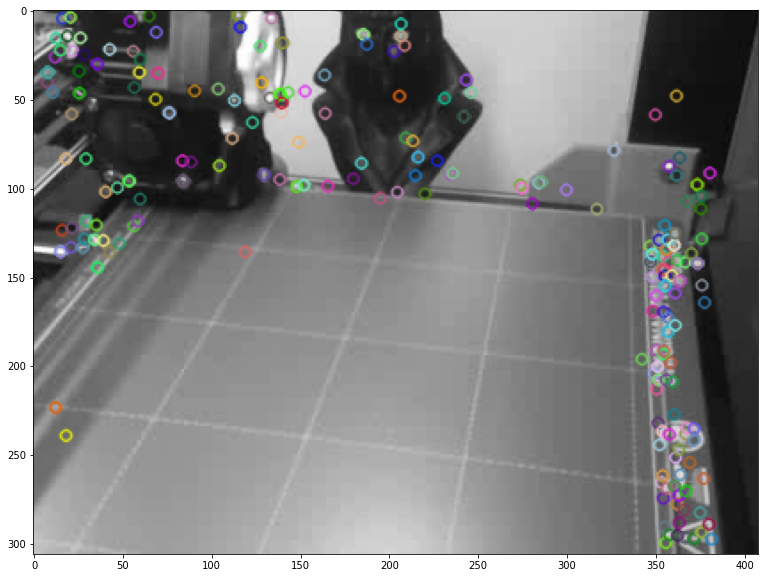

(True, array([[255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ..., 255,   0,   0],
        [  0,   0,   0, ..., 255,   0,   0],
        [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8))

In [67]:
frame = firstFrame[yMin:yMax,xMin:xMax]
kps, descs = extractSIFT(frame)

img3=cv2.drawKeypoints(frame,kps,frame)
print('!!!Croppoed image with SIFT overlay!!!')
plt.imshow(img3,),plt.show()


In [69]:
ret_sift,sift_mask = getFeaturesMask(frame, kps)